<a href="https://colab.research.google.com/github/MrFlygerian/portfolio-for-data-science/blob/master/Blessed_Image_Novoic_ML_challenge.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

___This is Blessed Chianumba's attempt at the Novoic ML challenge. An ongoing project.___

<a href="https://novoic.com"><img src="https://assets.novoic.com/logo_320px.png" alt="Novoic logo" width="160"/></a>

# Novoic ML challenge – image data

## Introduction
Welcome to the Novoic ML challenge!

This is an open-ended ML challenge to help us identify exceptional researchers and engineers. The guidance below describes an open-source dataset that you can use to demonstrate your research skills, creativity, coding ability, scientific communication or anything else you think is important to the role.

We recommend you spend around three hours on this (more or less if you wish), which you do not have to do in one go. Please make use of any resources you like. Feel free to shoot us an email with any questions that you might have!

This is the image version of the challenge. Also available are text and audio versions. You can access all three from [this GitHub repo](https://github.com/novoic/ml-challenge).

Best of luck – we're looking forward to seeing what you can do!

## Prepare the data
Copy the dataset to a local directory – this should take around 10 minutes.

In [ ]:
#@title
%%time

!mkdir -p data
!gsutil -m cp -r gs://novoic-ml-challenge-image-data/* ./data

## Data description

The data comprises 17,125 images in jpg format. Each image is of a realistic scene typically containing a number of objects.

There are 20 object classes of interest: aeroplane, bicycle, bird, boat, bottle, bus, car, cat, chair, cow, dining table, dog, horse, motorbike, person, potted plant, sheep, sofa, train, TV monitor. 

Each image is labelled with one of three numbers for each object class:
- -1 (no objects of this class feature in the image)
- 1 (at least one object of this class features in the image)
- 0 (at least one object of this class features in the image but they are all difficult to recognise)


In [ ]:
import IPython 
IPython.display.Image(filename='data/images/2012_004258.jpg') 

In [ ]:
IPython.display.Image(filename='data/images/2008_007739.jpg')

Each object class file (e.g. `aeroplane.txt`) contains the name of the image without the extension (e.g. `2008_007739`) followed by a space and then the class label (e.g. `-1`).

For more information about the dataset, see its `README.md`.

Directory structure:
```
data/
├── images/         # dir for jpg files
├── aeroplane.txt   # aeroplane object class labels
├── bicycle.txt     # bicycle object class labels
├── bird.txt        # bird object class labels
├── boat.txt        # boat object class labels
├── bottle.txt      # bottle object class labels
├── bus.txt         # bus object class labels
├── car.txt         # car object class labels
├── cat.txt         # cat object class labels
├── chair.txt       # chair object class labels
├── cow.txt         # cow object class labels
├── diningtable.txt # dining table object class labels
├── dog.txt         # dog object class labels
├── horse.txt       # horse object class labels
├── motorbike.txt   # motorbike object class labels
├── person.txt      # person object class labels
├── pottedplant.txt # potted plant object class labels
├── sheep.txt       # sheep object class labels
├── sofa.txt        # sofa object class labels
├── train.txt       # train object class labels
├── tvmonitor.txt   # TV monitor object class labels
├── LICENSE
└── README.md
```






## The challenge
This is an open-ended challenge and we want to witness your creativity. Some obvious suggestions:
- Data exploration/visualization
- Binary/multiclass classification
- Anomaly detection
- Unsupervised clustering
- Model explainability

You're welcome to explore one or more of these topics, or do something entirely different.

Create, iterate on, and validate your work in this notebook, using any packages of your choosing.

**You can access a GPU via `Runtime -> Change runtime type` in the toolbar.**

## Submission instructions
Once you're done, send us this `.ipynb` notebook (or a link to it hosted on Google Drive/GitHub with appropriate permissions) by email, ensuring that outputs from cells (text, plots etc) are preserved.

If you haven't applied already, make sure you submit an application first through our [job board](https://novoic.com/careers/).

## Your submission
The below sets up TensorFlow as an example but feel free to use any framework you like.

Take the wheel!

In [ ]:
# The default TensorFlow version on Colab is 1.x. Uncomment the below to use TensorFlow 2.x instead.
# %tensorflow_version 2.x

In [ ]:
import tensorflow as tf
tf.__version__

### Imports

In [ ]:
from numpy.random import seed
seed(888)
from tensorflow.compat.v1 import set_random_seed
set_random_seed(404)

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import glob
import os
import re

from keras.preprocessing.image import ImageDataGenerator
import keras.applications
from keras.models import Sequential
from keras.layers import Flatten, Dense, Input
from keras.preprocessing import image
from keras.callbacks import EarlyStopping, TensorBoard
from keras.models import load_model

import pickle



### Constants

In [ ]:
from google.colab import drive
drive.mount('/gdrive')


In [ ]:
DATA_DIR = 'data/'
IMAGE_DIR = 'data/images/'
LOG_DIR = 'tb_novoic_image_logs'

TXT_FNAMES = glob.glob(DATA_DIR + '*.txt')

VALID_SIZE = 100
BATCH_SIZE = 200  # Major factor in if the models actually run; larger batch sizes result in OOM error as resource runs out
EPOCHS = 50
IMG_SIZE = 256



## Data Preperation

Our data is in an odd format atm. Let's change it in to a form that keras can understand for augmentation and training. 

In [ ]:
sample_df = pd.read_csv(TXT_FNAMES[0], header=None, sep='\s+' )

In [ ]:
sample_df.head()

In [ ]:
frames = []

for name in TXT_FNAMES:
    frames.append(pd.read_csv(name, header=None, sep='\s+' ))

df = pd.concat(frames, axis=1)

cols = [re.findall(r'[ \w-]+?(?=\.)',fname) for fname in TXT_FNAMES]
cols = [item for fname in cols for item in fname]

df.index=df.iloc[:,0]
df.index = df.index +'.jpg'
df.index.name = 'image_file_path'
df = df.drop(columns=0)
df.columns = cols
df.reset_index(inplace=True)
df[df.columns[1:]]= df[df.columns[1:]].astype(float)


In [ ]:
df.head()

In [ ]:
df.shape

## Image modelling with Keras

We'll use keras to create and train our models with imagenet weights for transfer learning. Tensorboard will help us to see how our models are doing, and Early Stopping will terminate our training if the validation score doesn't imprve after a while.

In [ ]:
"""Only required if there is a dedicated GPU available"""
from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession

config = ConfigProto()
config = ConfigProto(device_count = {'GPU': 0})

config.gpu_options.allow_growth = True
session = InteractiveSession(config=config)

In [ ]:
# reset Keras Session
def reset_keras():
    sess = tf.compat.v1.keras.backend.get_session()
    tf.compat.v1.keras.backend.clear_session()
    sess.close()
    sess = tf.compat.v1.keras.backend.get_session()

    try:
        del classifier # this is from global space - change as required
    except:
        pass

    # use the same used to create the session
    config = tf.compat.v1.ConfigProto()
    config.gpu_options.per_process_gpu_memory_fraction = 1
    config.gpu_options.visible_device_list = "0"
    tf.compat.v1.keras.backend.set_session(tf.compat.v1.Session(config=config))
    
reset_keras()

In [ ]:
# Split original dataframe
from sklearn.model_selection import train_test_split
train, test = train_test_split(df[:-VALID_SIZE], test_size = 0.25)
print('train data shape:', train.shape, '\ntest data shape:', test.shape)


In [ ]:
datagen = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True)

In [ ]:
train_set=datagen.flow_from_dataframe(
    dataframe=train,
    directory=IMAGE_DIR,  
    x_col='image_file_path', 
    y_col=train.columns[1:],
    batch_size=BATCH_SIZE, 
    seed=42,
    shuffle=True,
    class_mode="raw",
    target_size=(IMG_SIZE,IMG_SIZE))

In [ ]:
test_set = datagen.flow_from_dataframe(
    dataframe=test,
    directory=IMAGE_DIR,
    x_col='image_file_path',
    y_col=test.columns[1:],
    batch_size=BATCH_SIZE,
    seed=42,
    shuffle=True,
    class_mode='raw',
    target_size=(IMG_SIZE,IMG_SIZE)
)

In [ ]:
output_layer = len(train.columns[1:])
print(output_layer)

In [ ]:
# functions for building models, running models and custom callbacks

# Buidling models
def build_model(architecture):
  model = Sequential()

  if architecture == 'VGG19':
    print('Using VGG19')
    model.add(keras.applications.vgg19.VGG19(weights='imagenet', include_top=False,
                                             input_tensor=Input(shape=(IMG_SIZE, IMG_SIZE, 3), name='input')))
    model.add(Flatten(name='flatten'))
    model.add(Dense(1000, activation='relu', name='fc1'))
    model.add(Dense(1000, activation='relu', name='fc2'))
    model.add(Dense(output_layer, activation='softmax', name='predictions'))

  elif architecture == 'InceptionResNetV2':
    print('Using InceptionResNetV2')
    model.add(tf.keras.applications.InceptionResNetV2(weights='imagenet', include_top=False,
                                                      input_tensor=Input(shape=(IMG_SIZE, IMG_SIZE, 3), name='input')))
    model.add(tf.keras.layers.Conv2D(filters=3000, kernel_size=(2,2),
                                     kernel_initializer='he_uniform', padding='same', activation='relu'))
    model.add(tf.keras.layers.AveragePooling2D(pool_size=2, strides=2))
    model.add(Flatten(name='flatten'))
    model.add(Dense(output_layer, activation='softmax', name='predictions'))

  else:
    print('Using ResNet50')
    model.add(keras.applications.resnet50.ResNet50(weights='imagenet', include_top=False,
                                                   input_tensor=Input(shape=(IMG_SIZE,IMG_SIZE, 3), name='input')))
    model.add(tf.keras.layers.Conv2D(filters=3000, kernel_size=(2,2),
                                     kernel_initializer='he_uniform', padding='same', activation='relu'))
    model.add(tf.keras.layers.AveragePooling2D(pool_size=2, strides=2))
    model.add(Flatten(name='flatten'))
    model.add(Dense(output_layer, activation='softmax', name='predictions'))
    
  model.compile(optimizer=keras.optimizers.RMSprop(lr=1e-4), loss='binary_crossentropy',
                  metrics=['accuracy', tf.keras.metrics.Precision()])
    
    
  return model

# custom callback(s)
def get_TB(name):
    

    folder_name = f'{name}_logs'
    dir_paths = os.path.join(LOG_DIR, folder_name)

    try:
        os.makedirs(dir_paths)
    except OSError as err:
        print (err.strerror)
    else:
        print ('made directory')

    return TensorBoard(log_dir=dir_paths, profile_batch=2, write_graph=True,
                       histogram_freq=1, embeddings_freq=1 )


# running models
def run_model(model, name):
  es = EarlyStopping(monitor='val_accuracy', mode='max', verbose=1, patience=7)
  tb = TensorBoard(log_dir=f'./{name}_logs', profile_batch=2, embeddings_freq=1, histogram_freq=1)

  history = model.fit(x = train_set, validation_data = test_set, epochs = EPOCHS, callbacks=[es, get_TB(name)])
  model.save(f'test_{name}.h5')
  with open(f'test_history_{name}', 'wb') as file_pi:
        pickle.dump(history.history, file_pi)
  
  model.summary()

  return history


In [ ]:
%%time

# Build and run InceptionResNetV2 Model
Inception_ResNet_model = build_model('InceptionResNetV2')
IR_history = run_model(Inception_ResNet_model, 'IR_model')

# Build and run VGG19 Model
VGG19_model = build_model('VGG19')
VGG19_history = run_model(VGG19_model, 'VGG19_model')

# Build and run ResNet Model
ResNet_model = build_model('ResNet')
ResNet_history = run_model(ResNet_model, 'ResNet_model')




####_Visualise training_ 

In [ ]:
# Get a visual on the model performance and structure

%load_ext tensorboard

# %reload_ext tensorboard
%tensorboard --logdir /tb_novoic_image_logs

## Making Predictions

Lets see how well our models do on data that hasn't already been seen.

In [ ]:
validation = df.iloc[-VALID_SIZE:]

In [ ]:
# Retrieve holdout set for real validation

holdout_set = datagen.flow_from_dataframe(
    dataframe=validation,
    directory=IMAGE_DIR,
    x_col='image_file_path',
    y_col=test.columns[1:],
    batch_size=BATCH_SIZE,
    seed=42,
    shuffle=True,
    class_mode='raw',
    target_size=(IMG_SIZE,IMG_SIZE))

In [ ]:
# display a few images 

import matplotlib.pyplot as plt
import matplotlib.image as mpimg

def process(filename: str=None) -> None:
    """
    View multiple images stored in files, stacking vertically

    Arguments:
        filename: str - path to filename containing image
    """
    image = mpimg.imread(filename)
    plt.figure()
    plt.axis('off')
    plt.imshow(image)

print('first 3 images of the holdout set')
for i in range(0,3):
    process(IMAGE_DIR + validation.iloc[i,0])

### Measure accuracy of models

In [ ]:
# function for testing model (validation data should be a var too)
def test_model(model_file_path, name, validation_dataset):
  model = load_model(model_file_path)

  pred_labels = np.argmax(model.predict(validation_dataset), axis = 1)
  pred_classes = [cols[i] for i in pred_labels]
  print('Predicted dominant image feature for the first 3 images: ', pred_classes[:3])
  acca = sum(np.equal(true_labels, pred_labels)) / len(true_labels)
  print(f"Accuracy of model {name}: {acca:.0%} " )

  return acca

In [ ]:
# function for getting model history
def get_model_history(history_file_path):
  with open(history_file_path, 'rb') as file:
    history=pickle.load(file)
  
  return history

In [ ]:
true_labels = np.argmax(holdout_set.labels, axis = 1)
true_classes = [cols[i] for i in true_labels]

print('Most dominant image feature for the first 3 images: ', true_classes[:3])

In [ ]:
ResNet_acca = test_model('test_ResNet_model.h5','ResNet', holdout_set)
VGG19_acca = test_model('test_VGG19_model.h5', 'VGG19', holdout_set)
IR_acca = test_model('test_IR_model.h5', 'InceptionResNet',holdout_set)

In [ ]:
IR_history = get_model_history('test_history_IR_model')
VGG19_history = get_model_history('test_VGG19_model.h5')
ResNet_history = get_model_history('test_history_ResNet_model')

In [192]:
def plot_history_metrics(history_object, colour):
  for i, ax in enumerate(fig.axes):
    ax.plot(range(0,len(history_object[list(history_object.keys())[i]])),
            history_object[list(history_object.keys())[i]], color = colour)
    ax.set_xlabel('Epoch', fontsize = 13)
    ax.set_ylabel(list(history_object.keys())[i], fontsize = 13)

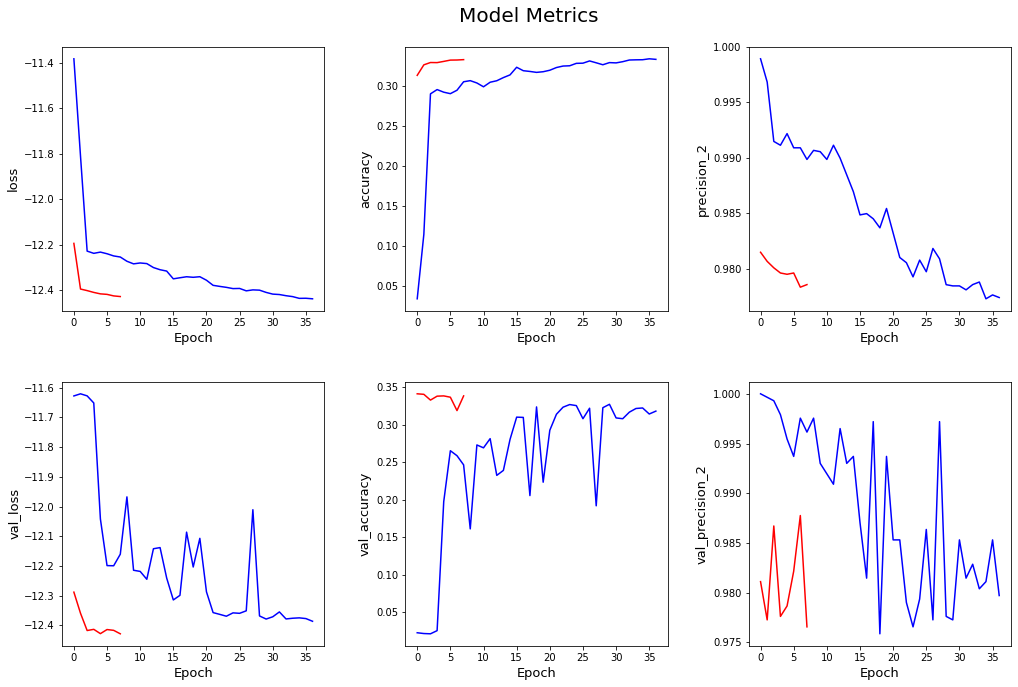

In [197]:
fig, axes = plt.subplots(2,3, figsize = (15,10))
fig.suptitle('Model Metrics', fontsize=20)
plt.tight_layout(pad = 5)

plot_history_metrics(IR_history, 'r')
plot_history_metrics(ResNet_history,'b')
plot_history_metrics(VGG19_history, 'g')


#### TO DO
- Create confusion matrix
- Create scatter plots and line plots with history data
- Solve resource problem (can't run with batches of over 200 samples atm) 